# Capstone Project

## Import relevant libraries

In [51]:
import os
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt


## Read data 

In [2]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 4000

data_dir = "engineered-data"
wege_df = pd.read_csv(os.path.join(data_dir, "wege.csv"), parse_dates=["Date"], index_col=["Date"])
bova_df = pd.read_csv(os.path.join(data_dir, "bova.csv"), parse_dates=["Date"], index_col=["Date"])

### Columns in dataset

In [3]:
print(wege_df.columns.values)

['Open' 'Max' 'Min' 'Close' 'Volume [BRL]' 'Volume [shares]'
 'IFR (RSI) [9]' 'True Range [1]' 'Moving Average A [21]'
 'Moving Average E [9]' 'IsLocalPeak' 'IsLocalTrough' 'derivative_peaks'
 'derivative_troughs' 'bear_harami' 'bull_harami' 'bear_engulfing'
 'bull_engulfing' 'hammer' 'shooting_star']


## Clean Data

Since we will use a single dataset (IBOVESPA index will be used to predict WEGE price), we will rename BOVA11's columns

In [4]:
 # Some features are not going to be used by the model. For instance, we cannot know whether a day was a local peak/trough untill its following day,
 # so we cannot use it as an input for predicting the next day.
cols_to_drop = ["IsLocalPeak","IsLocalTrough"]
for df in [wege_df, bova_df]:
    for col in cols_to_drop:
        df.drop(col, axis="columns", inplace=True, errors="ignore")
dict_colnames = {}
for column in bova_df.columns:
    dict_colnames[column] = "bova_" + column
bova_df.rename(columns=dict_colnames, inplace=True)


In [5]:
complete_df = pd.concat([bova_df, wege_df], axis=1, sort=False)
complete_df.dropna(inplace=True)
complete_df.drop(["bova_Date", "Date"], axis="columns", inplace=True, errors='ignore')
complete_df.drop("16/10/2020",inplace=True, errors="ignore") # since we don't have D+1 for our last day in the dataset
print(complete_df.columns.values)
complete_df.tail()

['bova_Open' 'bova_Max' 'bova_Min' 'bova_Close' 'bova_Volume [BRL]'
 'bova_Volume [shares]' 'bova_IFR (RSI) [9]' 'bova_True Range [1]'
 'bova_Moving Average A [21]' 'bova_Moving Average E [9]'
 'bova_derivative_peaks' 'bova_derivative_troughs' 'bova_bear_harami'
 'bova_bull_harami' 'bova_bear_engulfing' 'bova_bull_engulfing'
 'bova_hammer' 'bova_shooting_star' 'Open' 'Max' 'Min' 'Close'
 'Volume [BRL]' 'Volume [shares]' 'IFR (RSI) [9]' 'True Range [1]'
 'Moving Average A [21]' 'Moving Average E [9]' 'derivative_peaks'
 'derivative_troughs' 'bear_harami' 'bull_harami' 'bear_engulfing'
 'bull_engulfing' 'hammer' 'shooting_star']


,bova_Open,bova_Max,bova_Min,bova_Close,bova_Volume [BRL],bova_Volume [shares],bova_IFR (RSI) [9],bova_True Range [1],bova_Moving Average A [21],bova_Moving Average E [9],bova_derivative_peaks,bova_derivative_troughs,bova_bear_harami,bova_bull_harami,bova_bear_engulfing,bova_bull_engulfing,bova_hammer,bova_shooting_star,Open,Max,Min,Close,Volume [BRL],Volume [shares],IFR (RSI) [9],True Range [1],Moving Average A [21],Moving Average E [9],derivative_peaks,derivative_troughs,bear_harami,bull_harami,bear_engulfing,bull_engulfing,hammer,shooting_star
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-09,94.13,94.99,93.50,93.65,8.611634e+08,9149800.0,52.96,1.49,93.292381,92.710995,-0.143333,0.3025,0.000000,0.0,0.0,0.0,0.0,0.0,74.94,77.18,74.55,76.90,438389500.0,5745100,2.63,84.34,66.217619,71.205888,0.103333,0.0400,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-13,94.10,95.35,93.65,94.80,9.415492e+08,9960394.0,58.07,1.70,93.307619,93.128796,-0.143333,0.3025,0.000000,0.0,0.0,0.0,0.0,0.0,77.88,79.47,77.35,79.15,473625847.0,6030100,2.57,86.84,67.031429,72.794711,0.103333,0.0400,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-14,95.01,95.86,95.01,95.59,1.092614e+09,11431930.0,61.32,1.06,93.263810,93.621037,0.404000,0.3025,0.000000,0.0,0.0,0.0,0.0,0.0,79.26,80.98,79.26,80.58,527948834.0,6579000,1.83,88.19,67.854286,74.351768,0.103333,0.0400,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-15,94.36,95.80,94.05,95.34,9.081088e+08,9544784.0,59.67,1.75,93.210476,93.964830,0.404000,0.5540,0.000000,0.0,0.0,0.0,0.0,0.0,79.64,81.28,78.10,80.77,490407232.0,6096300,3.18,88.37,68.650476,75.635415,0.103333,1.2925,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-16,95.12,95.45,94.54,94.54,9.673009e+08,10188511.0,54.42,0.91,93.145238,94.079864,0.404000,0.5540,1.689655,0.0,0.0,0.0,0.0,0.0,81.06,83.36,80.91,82.05,525025471.0,6355600,2.59,89.56,69.561905,76.918332,0.103333,1.2925,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print(wege_df.index)
print(bova_df.index)
print(complete_df.index)

DatetimeIndex(['1994-07-04', '1994-07-05', '1994-07-06', '1994-07-07',
               '1994-07-08', '1994-07-11', '1994-07-12', '1994-07-27',
               '1994-07-28', '1994-08-03',
               ...
               '2020-10-02', '2020-10-05', '2020-10-06', '2020-10-07',
               '2020-10-08', '2020-10-09', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16'],
              dtype='datetime64[ns]', name='Date', length=5660, freq=None)
DatetimeIndex(['2008-12-02', '2008-12-03', '2008-12-04', '2008-12-05',
               '2008-12-08', '2008-12-09', '2008-12-10', '2008-12-11',
               '2008-12-12', '2008-12-15',
               ...
               '2020-10-02', '2020-10-05', '2020-10-06', '2020-10-07',
               '2020-10-08', '2020-10-09', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16'],
              dtype='datetime64[ns]', name='Date', length=2936, freq=None)
DatetimeIndex(['2008-12-12', '2008-12-15', '2008-12-16', '2008-12-17',

## Scale data

In [7]:
def scale_data(df, col_name, feature_range):
    scaler = MinMaxScaler(feature_range=feature_range)
    scaled_values = scaler.fit_transform(df[col_name].values.reshape(-1, 1))
    df[col_name] = scaled_values
    return (scaler, scaled_values)

In [8]:
dict_scalers = {}

for column_name in complete_df.columns:
    if pd.api.types.is_numeric_dtype(complete_df[column_name]):
        feature_range = (-1, 1) if min(complete_df[column_name].values) < 0 else (0, 1)
        dict_scalers[column_name] = scale_data(complete_df, column_name, feature_range)

In [9]:
#from: machinelearningmastery.com/blog/

def time_series_to_supervised(data, n_lag=1, n_fut=1, selLag=None, selFut=None, dropnan=True):
    """
    Converts a time series to a supervised learning data set by adding time-shifted prior and future period
    data as input or output (i.e., target result) columns for each period
    :param data:  a series of periodic attributes as a list or NumPy array
    :param n_lag: number of PRIOR periods to lag as input (X); generates: Xa(t-1), Xa(t-2); min= 0 --> nothing lagged
    :param n_fut: number of FUTURE periods to add as target output (y); generates Yout(t+1); min= 0 --> no future periods
    :param selLag:  only copy these specific PRIOR period attributes; default= None; EX: ['Xa', 'Xb' ]
    :param selFut:  only copy these specific FUTURE period attributes; default= None; EX: ['rslt', 'xx']
    :param dropnan: True= drop rows with NaN values; default= True
    :return: a Pandas DataFrame of time series data organized for supervised learning
    NOTES:
    (1) The current period's data is always included in the output.
    (2) A suffix is added to the original column names to indicate a relative time reference: e.g., (t) is the current
        period; (t-2) is from two periods in the past; (t+1) is from the next period
    (3) This is an extension of Jason Brownlee's series_to_supervised() function, customized for MFI use
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    origNames = df.columns
    cols, names = list(), list()
    # include all current period attributes
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]
 
    # lag any past period attributes (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # force valid number of lag periods
    for i in range(n_lag, 0, -1):
        suffix= '(t-%d)' % i
        if (None == selLag):   # copy all attributes from PRIOR periods?
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in (selLag):
                cols.append(df[var].shift(i))
                names+= [('%s%s' % (var, suffix))]
 
    # include future period attributes (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # force valid number of future periods to shift back
    for i in range(1, n_fut + 1):
        suffix= '(t+%d)' % i
        if (None == selFut):  # copy all attributes from future periods?
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copy only selected future attributes
            for var in (selFut):
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]
    # combine everything
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values introduced by lagging
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
data = time_series_to_supervised(complete_df, n_lag=5, n_fut=1, selLag=None, selFut=["Close"], dropnan=True)

### Split train/test data

We will use all the available data up untill October 15th 2019 as our training set. <br>
The remaining days, which correspond to one year of operations will be our test set.

In [11]:
cut_off = datetime(2019, 10, 15)
train = data[data.index < cut_off]
test = data[data.index > cut_off]
print (train.shape, test.shape)

(2673, 217) (248, 217)


In [12]:
train_data_dir = 'train_data'
train.to_csv(os.path.join(train_data_dir, 'train.csv'), columns=data.columns.values[::-1], header=False, index=False)

In [13]:
test_data_dir = 'test_data'
test.to_csv(os.path.join(test_data_dir, 'test.csv'), columns=data.columns.values[::-1], header=False, index=False)

## Upload data do S3

In [14]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/capstone'

role = sagemaker.get_execution_role()

In [15]:
input_data = sagemaker_session.upload_data(path=train_data_dir, bucket=bucket, key_prefix=prefix)

## Build and train the model

In [43]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 100,
                        'input_dim': train.shape[-1] - 1,
                        'hidden_dim': 200,
                        'num_layers': 5,
                        'output_dim': 1
                        
                    })

In [44]:
estimator.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-30 21:24:16 Starting - Starting the training job...
2020-10-30 21:24:18 Starting - Launching requested ML instances......
2020-10-30 21:25:21 Starting - Preparing the instances for training......
2020-10-30 21:26:31 Downloading - Downloading input data...
2020-10-30 21:26:56 Training - Downloading the training image...
2020-10-30 21:27:36 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-10-30 21:27:37,467 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-10-30 21:27:37,492 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-10-30 21:27:38,923 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-10-30 21:27:39,138 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-10-30 21:27:39,138 sagemake

## Deploy the model

In [45]:
predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------------!

## Testing the model

In [46]:
# # We split the data into chunks and send each chunk seperately, accumulating the results.

# def predict(data, rows=1):
#     split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
#     predictions = np.array([])
#     for array in split_array:
#         predictions = np.append(predictions, predictor.predict(array))
    
#     return predictions

In [47]:
import torch
test_data = pd.read_csv(os.path.join(test_data_dir, "test.csv"), header=None, names=None)
    
test_y = test_data[[0]].values
test_y = torch.from_numpy(test_y).float()

test_X = test_data.drop([0], axis=1).values
test_X = torch.from_numpy(test_X).float().unsqueeze(1)

In [48]:
predictions = predictor.predict(test_X)

In [50]:
print(predictions.size, test_y.size())
for i in range(len(predictions)):
    print(predictions[i, 0], test_y[i, 0])

248 torch.Size([248, 1])
0.25118572 tensor(0.2720)
0.25245747 tensor(0.2735)
0.25438017 tensor(0.2745)
0.25400057 tensor(0.2782)
0.25616226 tensor(0.2919)
0.25960162 tensor(0.2952)
0.26319695 tensor(0.2865)
0.266925 tensor(0.2887)
0.26889774 tensor(0.2879)
0.26976988 tensor(0.2920)
0.2701187 tensor(0.2877)
0.26962236 tensor(0.2924)
0.27010414 tensor(0.2956)
0.2697183 tensor(0.3031)
0.26964828 tensor(0.3085)
0.27127415 tensor(0.3199)
0.27256888 tensor(0.3218)
0.27469566 tensor(0.3323)
0.2756081 tensor(0.3251)
0.27667466 tensor(0.3338)
0.27778435 tensor(0.3345)
0.27805772 tensor(0.3350)
0.27811593 tensor(0.3337)
0.27805746 tensor(0.3298)
0.27756146 tensor(0.3320)
0.2775658 tensor(0.3325)
0.27590838 tensor(0.3267)
0.2754556 tensor(0.3318)
0.27594158 tensor(0.3366)
0.27572516 tensor(0.3489)
0.27705956 tensor(0.3458)
0.27866918 tensor(0.3525)
0.2800844 tensor(0.3663)
0.28154323 tensor(0.3781)
0.28352603 tensor(0.3778)
0.28572842 tensor(0.3675)
0.28665504 tensor(0.3682)
0.2872738 tensor(0.38

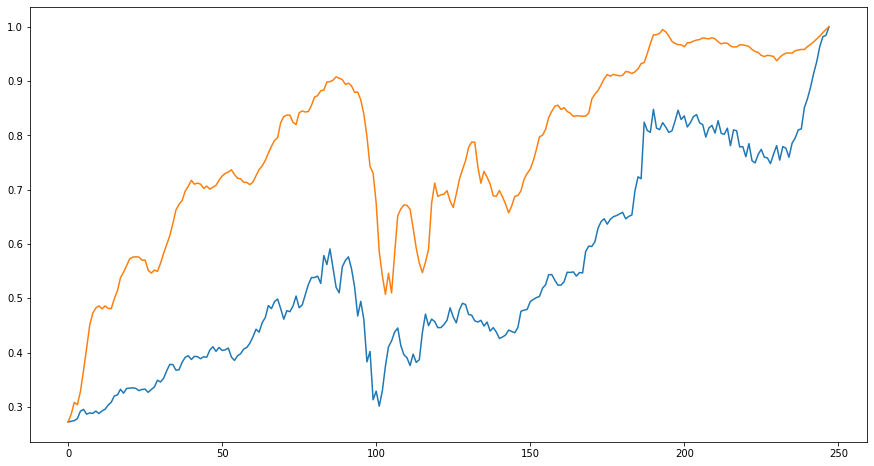

In [76]:
# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(test_y)
plt.plot(MinMaxScaler(feature_range=(0.2720, 1)).fit_transform(predictions))
plt.show()

In [65]:
train_data = pd.read_csv(os.path.join(train_data_dir, "train.csv"), header=None, names=None)
    
train_y = train_data[[0]].values
train_y = torch.from_numpy(train_y).float()

train_X = train_data.drop([0], axis=1).values
train_X = torch.from_numpy(train_X).float().unsqueeze(1)

In [66]:
predictions_train = predictor.predict(train_X)

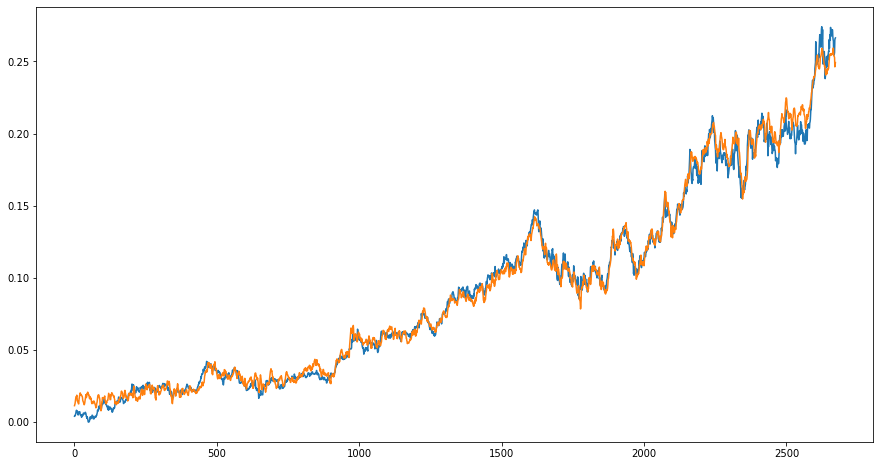

In [67]:
# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(train_y)
plt.plot(predictions_train)
plt.show()